In [1]:
import xarray as xr
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
from mpl_toolkits.axes_grid1 import make_axes_locatable

from metpy.plots import SkewT
from metpy.interpolate import cross_section

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt

from skimage.measure import label, regionprops
import pickle as pickle

from scipy import ndimage
import gc


In [2]:
#dhourmean
path = '/project/s916/davidle/RCE-LND/analysis/RCE_300_3km_1006x1006_ALL_ens?/'
file='dhourmean.nc'
all_dhourmean= xr.open_mfdataset(path+file, concat_dim='ens', combine='nested').squeeze()

#Wet-Day Frequency
path = '/project/s916/davidle/RCE-LND/analysis/RCE_300_3km_1006x1006_ALL_ens?/precip_stats/'
file='precip_wd_freq_2D_eq.nc'
all_wd_freq= xr.open_mfdataset(path+file, concat_dim='ens', combine='nested').squeeze()

#TWATER
path = '/project/s916/davidle/RCE-LND/analysis/ensmean/'
file='ensmean_daycycle_ALL.nc'
all_2D= xr.open_mfdataset(path+file)

#Landmask
path = '/project/s916/davidle/RCE-LND/RCE_300_3km_1006x1006_ALL_ens0/output/'
file='lffd2011032100c.nc'
all_const = xr.open_mfdataset(path+file).squeeze()

In [3]:
#dhourmean
path = '/project/s916/davidle/RCE-LND/analysis/RCE_300_3km_1006x1006_SMALL_ens?/'
file='dhourmean.nc'
small_dhourmean= xr.open_mfdataset(path+file, concat_dim='ens', combine='nested').squeeze()

#Wet-Day Frequency
path = '/project/s916/davidle/RCE-LND/analysis/RCE_300_3km_1006x1006_SMALL_ens?/precip_stats/'
file='precip_wd_freq_2D_eq.nc'
small_wd_freq= xr.open_mfdataset(path+file, concat_dim='ens', combine='nested').squeeze()

#TWATER
path = '/project/s916/davidle/RCE-LND/analysis/ensmean/'
file='ensmean_daycycle_SMALL.nc'
small_2D= xr.open_mfdataset(path+file)

#Landmask
path = '/project/s916/davidle/RCE-LND/RCE_300_3km_1006x1006_SMALL_ens0/output/'
file='lffd2011032100c.nc'
small_const = xr.open_mfdataset(path+file).squeeze()

In [3]:
all_fr_land = all_const.FR_LAND[4:-4,4:-4]
all_land = all_fr_land
all_coast = ndimage.binary_dilation(all_fr_land, iterations=20) - all_fr_land - (ndimage.binary_dilation(all_fr_land, iterations=3) - all_fr_land) #cost is 60km wide
all_ocean = np.ones_like(all_fr_land) - ndimage.binary_dilation(all_fr_land, iterations=20)

#Clip to wet regions
cwv = all_2D.TWATER.mean(axis=(0))
all_wetmask=np.where(cwv > np.percentile(cwv, 50), 1, 0)
all_drymask=np.where(cwv > np.percentile(cwv, 50), 0, 1)

all_wland=np.where(all_wetmask, all_land, 0)
all_wocean=np.where(all_wetmask, all_ocean, 0)
all_coastal_ocean=np.where(all_wetmask, all_coast, 0)
all_dry_ocean=np.where(all_drymask, all_ocean, 0)

In [5]:
small_fr_land = small_const.FR_LAND[4:-4,4:-4]
small_land = small_fr_land
small_coast = ndimage.binary_dilation(small_fr_land, iterations=20) - small_fr_land - (ndimage.binary_dilation(small_fr_land, iterations=3) - small_fr_land) #cost is 60km wide
small_ocean = np.ones_like(small_fr_land) - ndimage.binary_dilation(small_fr_land, iterations=20)

#Clip to wet regions
cwv = small_2D.TWATER.mean(axis=(0))
small_wetmask=np.where(cwv > np.percentile(cwv, 50), 1, 0)
small_drymask=np.where(cwv > np.percentile(cwv, 50), 0, 1)

small_wland=np.where(small_wetmask, small_land, 0)
small_wocean=np.where(small_wetmask, small_ocean, 0)
small_coastal_ocean=np.where(small_wetmask, small_coast, 0)
small_dry_ocean=np.where(small_drymask, small_ocean, 0)

In [4]:
def dc_wmean(fld,weights):
    #Compute diurnal cycle over a weighted field
    dcycle = np.zeros(24)
    for hh in range(len(dcycle)):
            dcycle[hh] = np.average(np.mean(fld[:,hh,:,:],axis=0),weights=weights)
    return np.hstack((dcycle,dcycle[0]))

In [5]:
def dc_wstd(fld,weights):
    #Compute diurnal cycle over a weighted field
    dcycle = np.zeros(24)
    helper=np.zeros(6)
    for hh in range(len(dcycle)):
        for ens in range(6):
            helper[ens]=np.average(fld[ens,hh,:,:],weights=weights)
        dcycle[hh] = np.std(helper)
    return np.hstack((dcycle,dcycle[0]))

In [8]:
def dc_wmean_2D(fld,weights):
    #Compute diurnal cycle over a weighted field
    dcycle = np.zeros(24)
    for hh in range(len(dcycle)):
            dcycle[hh] = np.average(fld[hh,:,:],weights=weights)
    return np.hstack((dcycle,dcycle[0]))

### Precipitation

Domain Mean
Mean P: 4.2031207
STD P: 0.5266479
Land
Mean P: 7.545963096618652
STD P: 2.3173680391669986
Coasts
Mean P: 4.9115832233428955
STD P: 0.837942242828887
Ocean
Mean P: 3.103078212738037
STD P: 0.8394089880483062


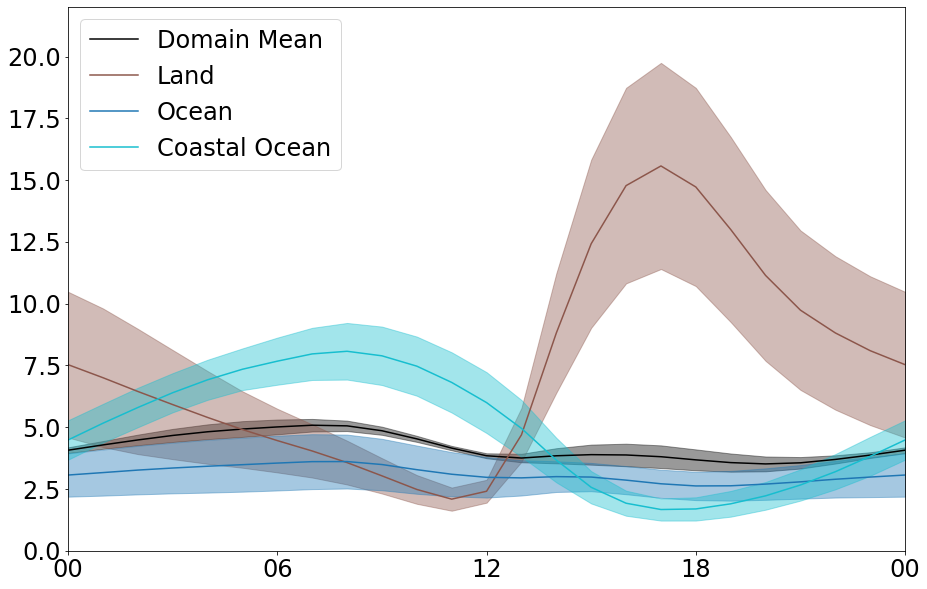

In [24]:
fld=all_dhourmean.TOT_PREC[:,:,1:-1,1:-1].values * 24

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 24})
plt.xlim(0,24)
plt.ylim(0,22)
plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])

plt.plot(dc_wmean(fld,np.ones_like(all_fr_land)), label='Domain Mean', color='k')
plt.fill_between(np.arange(25),dc_wmean(fld,np.ones_like(all_fr_land))+ dc_wstd(fld,np.ones_like(all_fr_land)) , dc_wmean(fld,np.ones_like(all_fr_land)) - dc_wstd(fld,np.ones_like(all_fr_land)), alpha=0.4, color='k')

plt.plot(dc_wmean(fld,all_fr_land), label='Land', color='C5')
plt.fill_between(np.arange(25),dc_wmean(fld,all_fr_land)+ dc_wstd(fld,all_fr_land) , dc_wmean(fld,all_fr_land) - dc_wstd(fld,all_fr_land), alpha=0.4, color='C5')

plt.plot(dc_wmean(fld,all_ocean - all_coast), label='Ocean', color='C0')
plt.fill_between(np.arange(25),dc_wmean(fld,all_ocean - all_coast)+ dc_wstd(fld,all_ocean - all_coast) , dc_wmean(fld,all_ocean - all_coast) - dc_wstd(fld,all_ocean - all_coast), alpha=0.4, color='C0')

plt.plot(dc_wmean(fld,all_coast), label='Coastal Ocean', color='C9')
plt.fill_between(np.arange(25),dc_wmean(fld,all_coast)+ dc_wstd(fld,all_coast) , dc_wmean(fld,all_coast) - dc_wstd(fld,all_coast), alpha=0.4, color='C9')

plt.legend()

plt.savefig('diurnal_cycle_P_ALL.pdf')

print("Domain Mean")
print("Mean P:", np.mean(fld))
print("STD P:", np.std(np.mean(fld,axis=(0,2,3))))

print("Land")
print("Mean P:", np.mean(dc_wmean(fld,all_fr_land)))
print("STD P:", np.mean(dc_wstd(fld,all_fr_land)))

print("Coasts")
print("Mean P:", np.mean(dc_wmean(fld,all_coast)))
print("STD P:", np.mean(dc_wstd(fld,all_coast)))

print("Ocean")
print("Mean P:", np.mean(dc_wmean(fld,all_ocean - all_coast)))
print("STD P:", np.mean(dc_wstd(fld,all_ocean - all_coast)))


Domain Mean
Mean P: 4.261993
STD P: 0.76522535
Land
Mean P: 6.326794080734253
STD P: 1.5456179045103609
Coasts
Mean P: 3.5836912202835083
STD P: 0.5263105424173976
Ocean
Mean P: 4.390706377029419
STD P: 0.46429757710195874


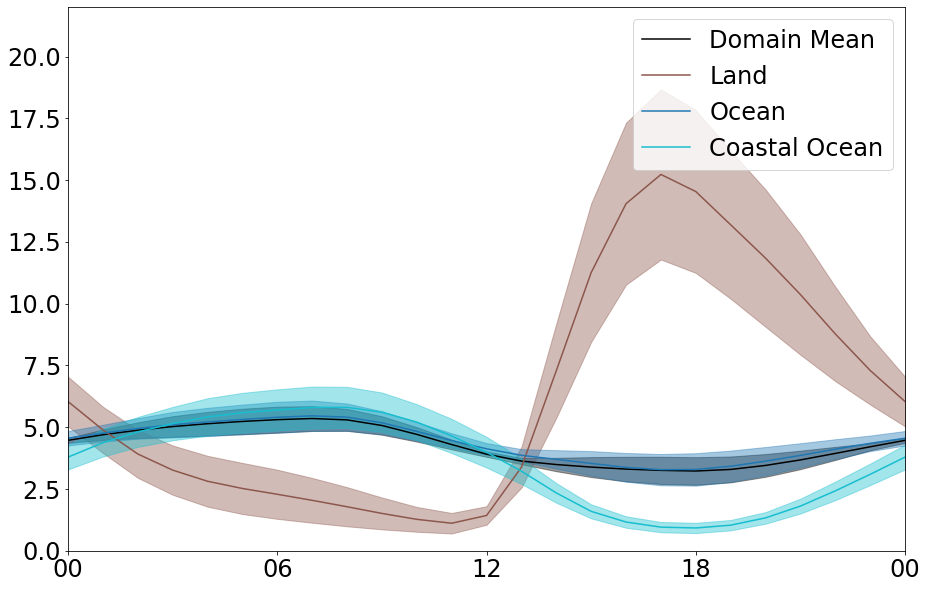

In [25]:
fld=small_dhourmean.TOT_PREC[:,:,1:-1,1:-1].values * 24

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 24})
plt.xlim(0,24)
plt.ylim(0,22)
plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])

plt.plot(dc_wmean(fld,np.ones_like(small_fr_land)), label='Domain Mean', color='k')
plt.fill_between(np.arange(25),dc_wmean(fld,np.ones_like(small_fr_land))+ dc_wstd(fld,np.ones_like(small_fr_land)) , dc_wmean(fld,np.ones_like(small_fr_land)) - dc_wstd(fld,np.ones_like(small_fr_land)), alpha=0.4, color='k')

plt.plot(dc_wmean(fld,small_fr_land), label='Land', color='C5')
plt.fill_between(np.arange(25),dc_wmean(fld,small_fr_land)+ dc_wstd(fld,small_fr_land) , dc_wmean(fld,small_fr_land) - dc_wstd(fld,small_fr_land), alpha=0.4, color='C5')

plt.plot(dc_wmean(fld,small_ocean - small_coast), label='Ocean', color='C0')
plt.fill_between(np.arange(25),dc_wmean(fld,small_ocean - small_coast)+ dc_wstd(fld,small_ocean - small_coast) , dc_wmean(fld,small_ocean - small_coast) - dc_wstd(fld,small_ocean - small_coast), alpha=0.4, color='C0')

plt.plot(dc_wmean(fld,small_coast), label='Coastal Ocean', color='C9')
plt.fill_between(np.arange(25),dc_wmean(fld,small_coast)+ dc_wstd(fld,small_coast) , dc_wmean(fld,small_coast) - dc_wstd(fld,small_coast), alpha=0.4, color='C9')

plt.legend()

plt.savefig('diurnal_cycle_P_small.pdf')

print("Domain Mean")
print("Mean P:", np.mean(fld))
print("STD P:", np.std(np.mean(fld,axis=(0,2,3))))

print("Land")
print("Mean P:", np.mean(dc_wmean(fld,small_fr_land)))
print("STD P:", np.mean(dc_wstd(fld,small_fr_land)))

print("Coasts")
print("Mean P:", np.mean(dc_wmean(fld,small_coast)))
print("STD P:", np.mean(dc_wstd(fld,small_coast)))

print("Ocean")
print("Mean P:", np.mean(dc_wmean(fld,small_ocean - small_coast)))
print("STD P:", np.mean(dc_wstd(fld,small_ocean - small_coast)))


### Surface Latent Heatflux

133.1588 113.09467229074586 75.22884 123.61169 120.43751
1 0.42245309082525284 0.055961367228858416 0.23767343969004676 0.09853848328256927


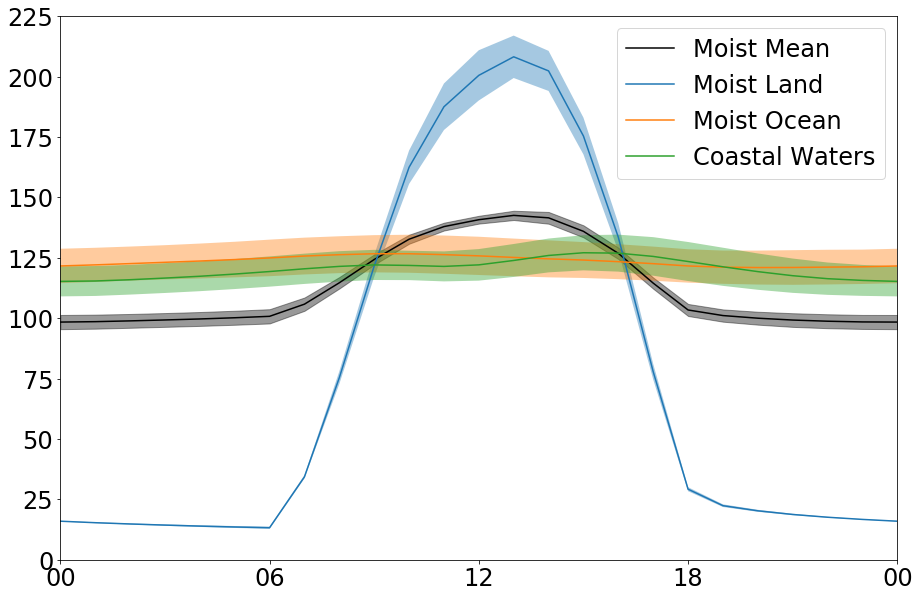

In [9]:
fld=all_dhourmean.LHFL_S[:,:,1:-1,1:-1].values * (-1)

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 24})
plt.xlim(0,24)
plt.ylim(0,225)
plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])

plt.plot(dc_wmean(fld,all_wetmask), label='Moist Mean', color='k')
plt.fill_between(np.arange(25),dc_wmean(fld,all_wetmask)+ dc_wstd(fld,all_wetmask) , dc_wmean(fld,all_wetmask) - dc_wstd(fld,all_wetmask), alpha=0.4, color='k')

plt.plot(dc_wmean(fld,all_wland), label='Moist Land')
plt.fill_between(np.arange(25),dc_wmean(fld,all_wland)+ dc_wstd(fld,all_wland) , dc_wmean(fld,all_wland) - dc_wstd(fld,all_wland), alpha=0.4)

plt.plot(dc_wmean(fld,all_wocean), label='Moist Ocean')
plt.fill_between(np.arange(25),dc_wmean(fld,all_wocean)+ dc_wstd(fld,all_wocean) , dc_wmean(fld,all_wocean) - dc_wstd(fld,all_wocean), alpha=0.4)

plt.plot(dc_wmean(fld,all_coastal_ocean), label='Coastal Waters')
plt.fill_between(np.arange(25),dc_wmean(fld,all_coastal_ocean)+ dc_wstd(fld,all_coastal_ocean) , dc_wmean(fld,all_coastal_ocean) - dc_wstd(fld,all_coastal_ocean), alpha=0.4)

plt.legend()

plt.savefig('latent_heatflux_ALL.pdf')

print(np.mean(fld), np.average(fld,weights=np.tile(all_wetmask, (6,24,1,1))),  np.average(fld,weights=np.tile(all_wland, (6,24,1,1))), np.average(fld,weights=np.tile(all_wocean, (6,24,1,1))),np.average(fld,weights=np.tile(all_coastal_ocean, (6,24,1,1))))

totprec=np.mean(fld) * 998 * 998
print(1, np.mean(dc_wmean(fld,all_wetmask)) * np.sum(all_wetmask) / totprec,  np.mean(dc_wmean(fld,all_wland)) * np.sum(all_wland) / totprec, np.mean(dc_wmean(fld,all_wocean)) * np.sum(all_wocean) / totprec, np.mean(dc_wmean(fld,all_coastal_ocean)) * np.sum(all_coastal_ocean) / totprec)


In [14]:
LH=all_dhourmean.LHFL_S[:,:,1:-1,1:-1].values * (-1)
SH=all_dhourmean.SHFL_S[:,:,1:-1,1:-1].values * (-1)

LH_l = np.abs(dc_wmean(LH,all_land))[12]
SH_l = np.abs(dc_wmean(SH,all_land))[12]

LH_o = np.abs(dc_wmean(LH,all_ocean))[12]
SH_o = np.abs(dc_wmean(SH,all_ocean))[12]

print(SH_l / LH_l)
print(SH_o / LH_o)

0.655587415004031
0.008828175294674275


134.75987 121.34988927492624 74.36566 124.25936 119.79368
1 0.4496137324053067 0.01295315573132766 0.38120523285465757 0.0438149939745262


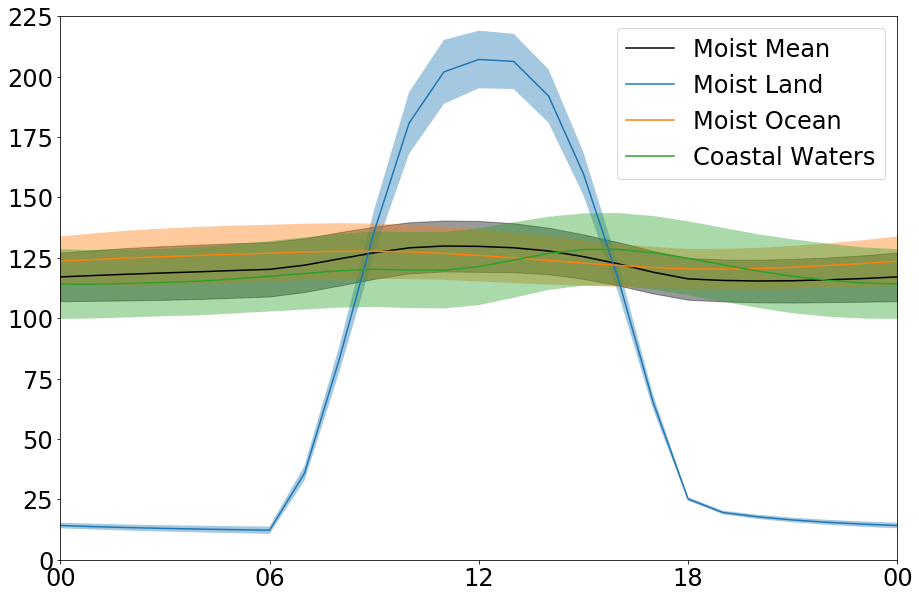

In [16]:
fld=small_dhourmean.LHFL_S[:,:,1:-1,1:-1].values * (-1)

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 24})
plt.xlim(0,24)
plt.ylim(0,225)
plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])

plt.plot(dc_wmean(fld,small_wetmask), label='Moist Mean', color='k')
plt.fill_between(np.arange(25),dc_wmean(fld,small_wetmask)+ dc_wstd(fld,small_wetmask) , dc_wmean(fld,small_wetmask) - dc_wstd(fld,small_wetmask), alpha=0.4, color='k')

plt.plot(dc_wmean(fld,small_wland), label='Moist Land')
plt.fill_between(np.arange(25),dc_wmean(fld,small_wland)+ dc_wstd(fld,small_wland) , dc_wmean(fld,small_wland) - dc_wstd(fld,small_wland), alpha=0.4)

plt.plot(dc_wmean(fld,small_wocean), label='Moist Ocean')
plt.fill_between(np.arange(25),dc_wmean(fld,small_wocean)+ dc_wstd(fld,small_wocean) , dc_wmean(fld,small_wocean) - dc_wstd(fld,small_wocean), alpha=0.4)

plt.plot(dc_wmean(fld,small_coastal_ocean), label='Coastal Waters')
plt.fill_between(np.arange(25),dc_wmean(fld,small_coastal_ocean)+ dc_wstd(fld,small_coastal_ocean) , dc_wmean(fld,small_coastal_ocean) - dc_wstd(fld,small_coastal_ocean), alpha=0.4)

plt.legend()

plt.savefig('latent_heatflux_SMALL.pdf')

print(np.mean(fld), np.average(fld,weights=np.tile(small_wetmask, (6,24,1,1))),  np.average(fld,weights=np.tile(small_wland, (6,24,1,1))), np.average(fld,weights=np.tile(small_wocean, (6,24,1,1))),np.average(fld,weights=np.tile(small_coastal_ocean, (6,24,1,1))))

totprec=np.mean(fld) * 998 * 998
print(1, np.mean(dc_wmean(fld,small_wetmask)) * np.sum(small_wetmask) / totprec,  np.mean(dc_wmean(fld,small_wland)) * np.sum(small_wland) / totprec, np.mean(dc_wmean(fld,small_wocean)) * np.sum(small_wocean) / totprec, np.mean(dc_wmean(fld,small_coastal_ocean)) * np.sum(small_coastal_ocean) / totprec)


### Surface Sensible Heatflux

1.2324541 2.756991122303593 25.623451 -2.9347315 -3.5869913
1 0.9678404720915722 1.9776039400656933 -0.6116234658487842 -0.3191494597723864


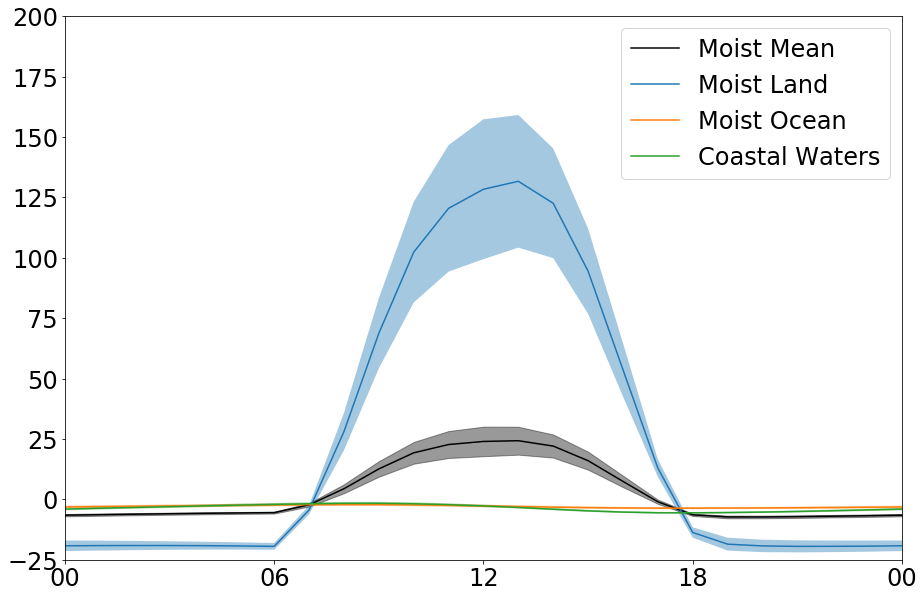

In [25]:
fld=all_dhourmean.SHFL_S[:,:,1:-1,1:-1].values * (-1)

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 24})
plt.xlim(0,24)
plt.ylim(-25,200)
plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])

plt.plot(dc_wmean(fld,all_wetmask), label='Moist Mean', color='k')
plt.fill_between(np.arange(25),dc_wmean(fld,all_wetmask)+ dc_wstd(fld,all_wetmask) , dc_wmean(fld,all_wetmask) - dc_wstd(fld,all_wetmask), alpha=0.4, color='k')

plt.plot(dc_wmean(fld,all_wland), label='Moist Land')
plt.fill_between(np.arange(25),dc_wmean(fld,all_wland)+ dc_wstd(fld,all_wland) , dc_wmean(fld,all_wland) - dc_wstd(fld,all_wland), alpha=0.4)

plt.plot(dc_wmean(fld,all_wocean), label='Moist Ocean')
plt.fill_between(np.arange(25),dc_wmean(fld,all_wocean)+ dc_wstd(fld,all_wocean) , dc_wmean(fld,all_wocean) - dc_wstd(fld,all_wocean), alpha=0.4)

plt.plot(dc_wmean(fld,all_coastal_ocean), label='Coastal Waters')
plt.fill_between(np.arange(25),dc_wmean(fld,all_coastal_ocean)+ dc_wstd(fld,all_coastal_ocean) , dc_wmean(fld,all_coastal_ocean) - dc_wstd(fld,all_coastal_ocean), alpha=0.4)

plt.legend()

plt.savefig('sensible_heatflux_ALL.pdf')

print(np.mean(fld), np.average(fld,weights=np.tile(all_wetmask, (6,24,1,1))),  np.average(fld,weights=np.tile(all_wland, (6,24,1,1))), np.average(fld,weights=np.tile(all_wocean, (6,24,1,1))),np.average(fld,weights=np.tile(all_coastal_ocean, (6,24,1,1))))

totprec=np.mean(fld) * 998 * 998
print(1, np.mean(dc_wmean(fld,all_wetmask)) * np.sum(all_wetmask) / totprec,  np.mean(dc_wmean(fld,all_wland)) * np.sum(all_wland) / totprec, np.mean(dc_wmean(fld,all_wocean)) * np.sum(all_wocean) / totprec, np.mean(dc_wmean(fld,all_coastal_ocean)) * np.sum(all_coastal_ocean) / totprec)


0.43170562 -0.9907922944371358 30.238476 -2.4828002 -3.4559207
1 -1.2614208296391247 1.5897644584482913 -2.384191103463442 -0.3959696809418234


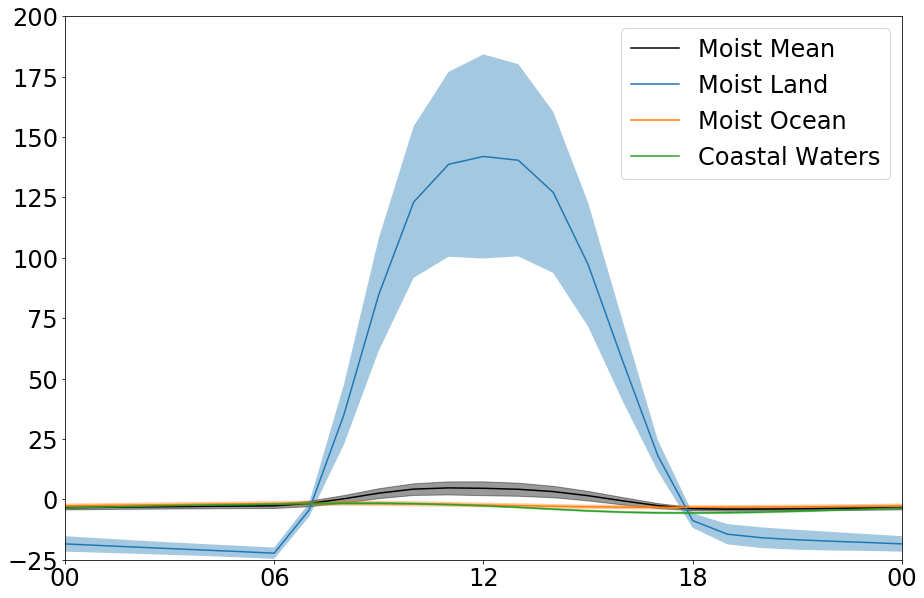

In [24]:
fld=small_dhourmean.SHFL_S[:,:,1:-1,1:-1].values * (-1)

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 24})
plt.xlim(0,24)
plt.ylim(-25,200)
plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])

plt.plot(dc_wmean(fld,small_wetmask), label='Moist Mean', color='k')
plt.fill_between(np.arange(25),dc_wmean(fld,small_wetmask)+ dc_wstd(fld,small_wetmask) , dc_wmean(fld,small_wetmask) - dc_wstd(fld,small_wetmask), alpha=0.4, color='k')

plt.plot(dc_wmean(fld,small_wland), label='Moist Land')
plt.fill_between(np.arange(25),dc_wmean(fld,small_wland)+ dc_wstd(fld,small_wland) , dc_wmean(fld,small_wland) - dc_wstd(fld,small_wland), alpha=0.4)

plt.plot(dc_wmean(fld,small_wocean), label='Moist Ocean')
plt.fill_between(np.arange(25),dc_wmean(fld,small_wocean)+ dc_wstd(fld,small_wocean) , dc_wmean(fld,small_wocean) - dc_wstd(fld,small_wocean), alpha=0.4)

plt.plot(dc_wmean(fld,small_coastal_ocean), label='Coastal Waters')
plt.fill_between(np.arange(25),dc_wmean(fld,small_coastal_ocean)+ dc_wstd(fld,small_coastal_ocean) , dc_wmean(fld,small_coastal_ocean) - dc_wstd(fld,small_coastal_ocean), alpha=0.4)

plt.legend()

plt.savefig('sensible_heatflux_SMALL.pdf')

print(np.mean(fld), np.average(fld,weights=np.tile(small_wetmask, (6,24,1,1))),  np.average(fld,weights=np.tile(small_wland, (6,24,1,1))), np.average(fld,weights=np.tile(small_wocean, (6,24,1,1))),np.average(fld,weights=np.tile(small_coastal_ocean, (6,24,1,1))))

totprec=np.mean(fld) * 998 * 998
print(1, np.mean(dc_wmean(fld,small_wetmask)) * np.sum(small_wetmask) / totprec,  np.mean(dc_wmean(fld,small_wland)) * np.sum(small_wland) / totprec, np.mean(dc_wmean(fld,small_wocean)) * np.sum(small_wocean) / totprec, np.mean(dc_wmean(fld,small_coastal_ocean)) * np.sum(small_coastal_ocean) / totprec)


# Virtual Temperature

In [6]:
def dc_wmean_3D(fld,weights):
    #Compute diurnal cycle over a weighted field
    dcycle = np.zeros((24,74))
    for hh in range(len(dcycle)):
        for k in range(74):
            dcycle[hh,k] = np.average(fld[hh,k,:,:], weights=weights)
    return np.vstack((dcycle,np.expand_dims(dcycle[0,:], axis=0)))


In [7]:
%%capture
path = '/project/s916/davidle/RCE-LND/analysis/ensmean/'
file='ensmean_daycycle_ALL_3D_P.nc'
all_P = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_ALL_3D_T.nc'
all_T = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_ALL_3D_QV.nc'
all_QV = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_ALL_3D_QC.nc'
all_QC = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_ALL_3D_RELHUM.nc'
all_RELHUM = xr.open_mfdataset(path+file).squeeze()

In [8]:
%%capture
#dhourmean
path = '/project/s916/davidle/RCE-LND/analysis/RCE_300_3km_1006x1006_ALL_ens?/'
file='dhourmean_3D.nc'
all_dhourmean_3D= xr.open_mfdataset(path+file, concat_dim='ens', combine='nested').squeeze()

In [7]:
plevel=500
lvl = (np.abs(np.mean(all_P.P,axis=(0,2,3))/100 - plevel)).argmin()

In [8]:
all_Tv = np.array(mpcalc.virtual_temperature(all_T.T.isel(level=lvl.values), mpcalc.mixing_ratio_from_relative_humidity(all_RELHUM.RELHUM.isel(level=lvl.values), all_T.T.isel(level=lvl.values), all_P.P.isel(level=lvl.values))))

In [ ]:
all_ens_Tv = np.array(mpcalc.virtual_temperature(all_dhourmean_3D.isel(level=lvl.values).T, mpcalc.mixing_ratio_from_relative_humidity(all_dhourmean_3D.isel(level=lvl.values).RELHUM, all_dhourmean_3D.isel(level=lvl.values).T, all_dhourmean_3D.isel(level=lvl.values).P)))

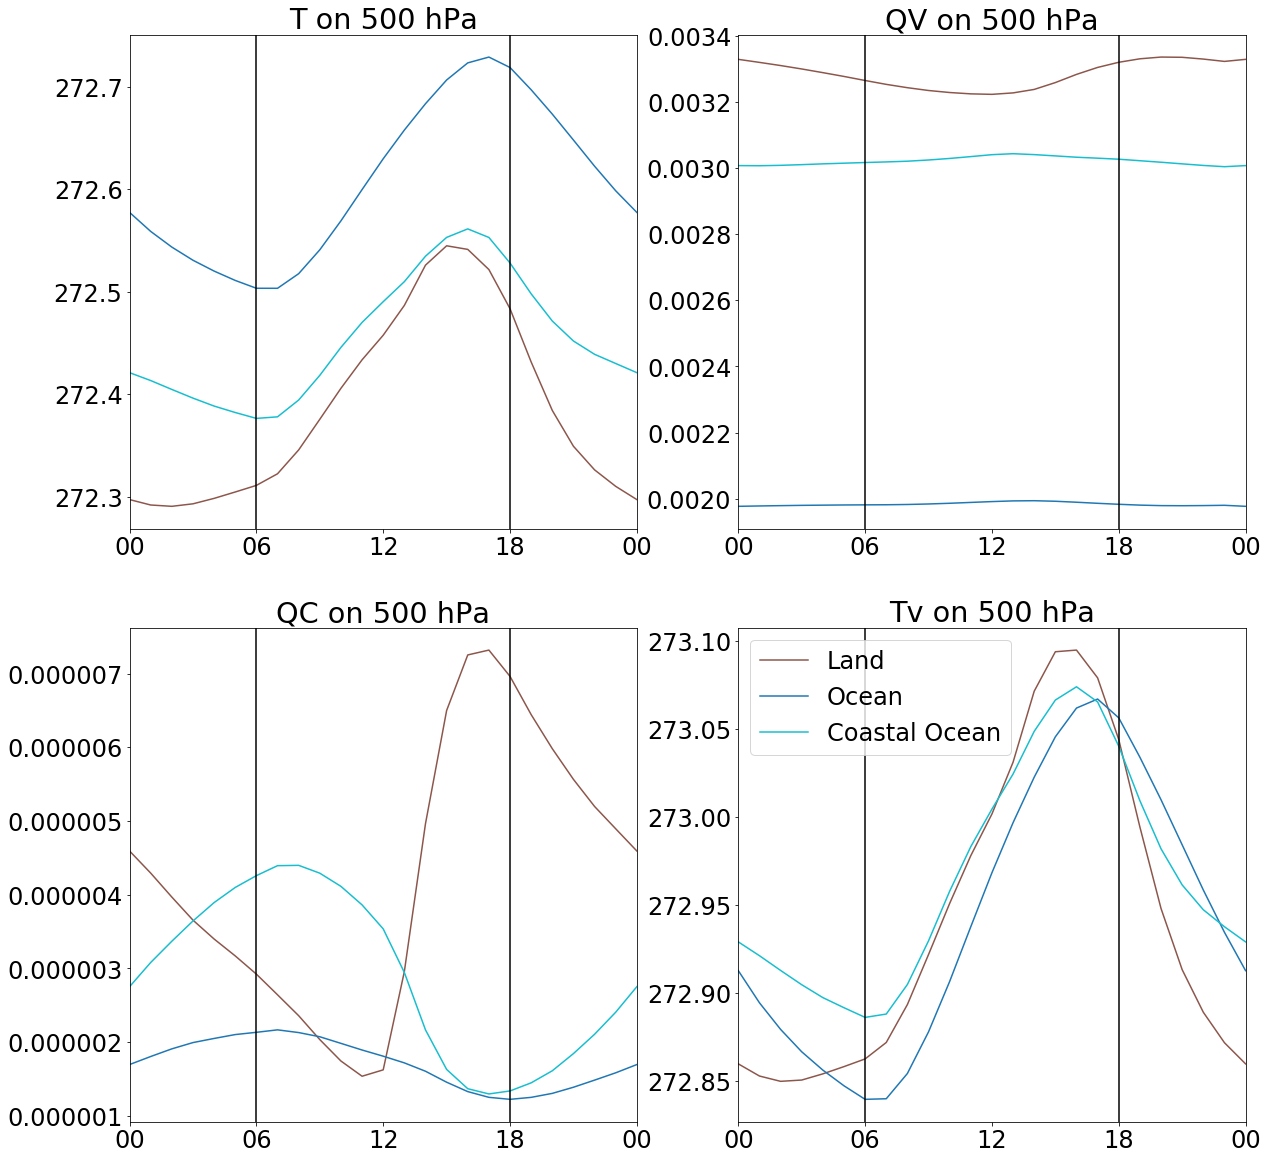

In [45]:
#Diurnal cycle of Tv between 500 and 300 hPa
plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 24})



ax = plt.subplot(2,2,1)
plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])
plt.xlim(0,24)
#plt.ylim(338,347)
plt.title('T on 500 hPa')

plt.plot(dc_wmean_2D(all_T.T.isel(level=lvl.values),all_wland), label="Land", color='C5')
plt.plot(dc_wmean_2D(all_T.T.isel(level=lvl.values),all_ocean), label="Ocean", color='C0')
plt.plot(dc_wmean_2D(all_T.T.isel(level=lvl.values),all_coastal_ocean), label="Coastal Ocean", color='C9')

plt.axvline(x=6.0, color='k')
plt.axvline(x=18.0, color='k')


ax = plt.subplot(2,2,2)
plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])
plt.xlim(0,24)
#plt.ylim(338,347)
plt.title('QV on 500 hPa')

plt.plot(dc_wmean_2D(all_QV.QV.isel(level=lvl.values),all_wland), label="Land", color='C5')
plt.plot(dc_wmean_2D(all_QV.QV.isel(level=lvl.values),all_ocean), label="Ocean", color='C0')
plt.plot(dc_wmean_2D(all_QV.QV.isel(level=lvl.values),all_coastal_ocean), label="Coastal Ocean", color='C9')

plt.axvline(x=6.0, color='k')
plt.axvline(x=18.0, color='k')

ax = plt.subplot(2,2,3)
plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])
plt.xlim(0,24)
#plt.ylim(338,347)
plt.title('QC on 500 hPa')

plt.plot(dc_wmean_2D(all_QC.QC.isel(level=lvl.values),all_wland), label="Land", color='C5')
plt.plot(dc_wmean_2D(all_QC.QC.isel(level=lvl.values),all_ocean), label="Ocean", color='C0')
plt.plot(dc_wmean_2D(all_QC.QC.isel(level=lvl.values),all_coastal_ocean), label="Coastal Ocean", color='C9')

plt.axvline(x=6.0, color='k')
plt.axvline(x=18.0, color='k')

ax = plt.subplot(2,2,4)
plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])
plt.xlim(0,24)
#plt.ylim(338,347)
plt.title('Tv on 500 hPa')

plt.plot(dc_wmean_2D(all_Tv, all_wland)[:], label="Land", color='C5')
plt.plot(dc_wmean_2D(all_Tv,all_ocean)[:], label="Ocean", color='C0')
plt.plot(dc_wmean_2D(all_Tv,all_coastal_ocean)[:], label="Coastal Ocean", color='C9')

plt.axvline(x=6.0, color='k')
plt.axvline(x=18.0, color='k')

plt.legend()

plt.savefig('Tv_Diurnal_Cycle.pdf')

# Land Drying

In [9]:
#dhourmean
path = '/scratch/snx3000/davidle/tropical_islands_dcycle/RCE_300_3km_1006x1006_ALL_ens?/'
file='dhourmean_3D.nc'
all_dhourmean_3D= xr.open_mfdataset(path+file, concat_dim='ens', combine='nested').squeeze()

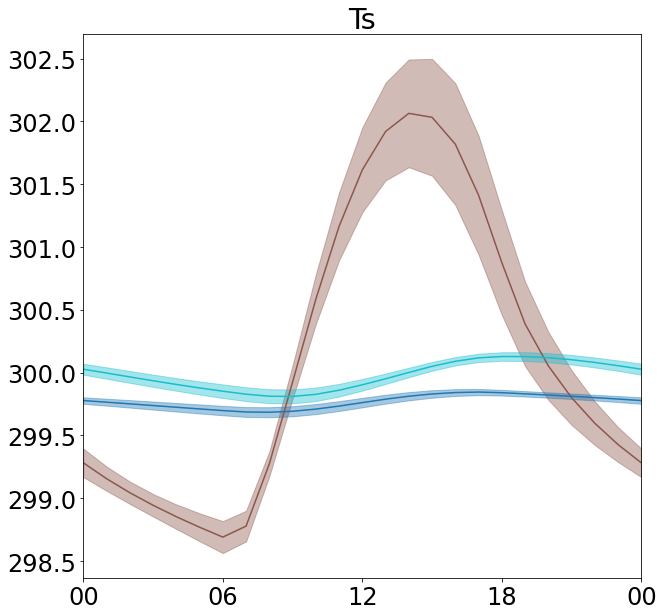

In [18]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 24})


#Temperature
fld = all_dhourmean_3D.T[:,:,-1,1:-1,1:-1].values

plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])
plt.xlim(0,24)
#plt.ylim(338,347)
plt.title('Ts')

plt.plot(dc_wmean(fld,all_wland), label='Land', color='C5')
plt.fill_between(np.arange(25),dc_wmean(fld,all_wland)+ dc_wstd(fld,all_wland) , dc_wmean(fld,all_wland) - dc_wstd(fld,all_wland), alpha=0.4, color='C5')

plt.plot(dc_wmean(fld,all_ocean), label='Ocean', color='C0')
plt.fill_between(np.arange(25),dc_wmean(fld,all_ocean)+ dc_wstd(fld,all_ocean) , dc_wmean(fld,all_ocean) - dc_wstd(fld,all_ocean), alpha=0.4, color='C0')

plt.plot(dc_wmean(fld,all_coastal_ocean), label='Coastal Ocean', color='C9')
plt.fill_between(np.arange(25),dc_wmean(fld,all_coastal_ocean)+ dc_wstd(fld,all_coastal_ocean) , dc_wmean(fld,all_coastal_ocean) - dc_wstd(fld,all_coastal_ocean), alpha=0.4, color='C9')

plt.savefig('T_Diurnal_Cycle.pdf')



In [ ]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 24})

#Moisture
fld = all_dhourmean_3D.QV[:,:,-1,1:-1,1:-1]

plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])
plt.xlim(0,24)
#plt.ylim(338,347)
plt.title('QVs')

plt.plot(dc_wmean(fld,all_wland), label='Land', color='C5')
plt.fill_between(np.arange(25),dc_wmean(fld,all_wland)+ dc_wstd(fld,all_wland) , dc_wmean(fld,all_wland) - dc_wstd(fld,all_wland), alpha=0.4, color='C5')

plt.plot(dc_wmean(fld,all_ocean), label='Ocean', color='C0')
plt.fill_between(np.arange(25),dc_wmean(fld,all_ocean)+ dc_wstd(fld,all_ocean) , dc_wmean(fld,all_ocean) - dc_wstd(fld,all_ocean), alpha=0.4, color='C0')

plt.plot(dc_wmean(fld,all_coastal_ocean), label='Coastal Ocean', color='C9')
plt.fill_between(np.arange(25),dc_wmean(fld,all_coastal_ocean)+ dc_wstd(fld,all_coastal_ocean) , dc_wmean(fld,all_coastal_ocean) - dc_wstd(fld,all_coastal_ocean), alpha=0.4, color='C9')


plt.savefig('QV_Diurnal_Cycle.pdf')

In [ ]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 24})

#Relative Humidity
fld = all_dhourmean_3D.RELHUM[:,:,-1,1:-1,1:-1]

plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])
plt.xlim(0,24)
#plt.ylim(338,347)
plt.title('RHs')

plt.plot(dc_wmean(fld,all_wland), label='Land', color='C5')
plt.fill_between(np.arange(25),dc_wmean(fld,all_wland)+ dc_wstd(fld,all_wland) , dc_wmean(fld,all_wland) - dc_wstd(fld,all_wland), alpha=0.4, color='C5')

plt.plot(dc_wmean(fld,all_ocean), label='Ocean', color='C0')
plt.fill_between(np.arange(25),dc_wmean(fld,all_ocean)+ dc_wstd(fld,all_ocean) , dc_wmean(fld,all_ocean) - dc_wstd(fld,all_ocean), alpha=0.4, color='C0')

plt.plot(dc_wmean(fld,all_coastal_ocean), label='Coastal Ocean', color='C9')
plt.fill_between(np.arange(25),dc_wmean(fld,all_coastal_ocean)+ dc_wstd(fld,all_coastal_ocean) , dc_wmean(fld,all_coastal_ocean) - dc_wstd(fld,all_coastal_ocean), alpha=0.4, color='C9')

plt.savefig('RH_Diurnal_Cycle.pdf')

In [ ]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 24})

#Bowen Ratio
Bo=all_dhourmean.SHFL_S / all_dhourmean.LHFL_S
fld = Bo[:,:,-1,1:-1,1:-1].values

plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])
plt.xlim(0,24)
#plt.ylim(338,347)
plt.title('Bo')

plt.plot(dc_wmean(fld,all_wland), label='Land', color='C5')
plt.fill_between(np.arange(25),dc_wmean(fld,all_wland)+ dc_wstd(fld,all_wland) , dc_wmean(fld,all_wland) - dc_wstd(fld,all_wland), alpha=0.4, color='C5')

plt.plot(dc_wmean(fld,all_ocean), label='Ocean', color='C0')
plt.fill_between(np.arange(25),dc_wmean(fld,all_ocean)+ dc_wstd(fld,all_ocean) , dc_wmean(fld,all_ocean) - dc_wstd(fld,all_ocean), alpha=0.4, color='C0')

plt.plot(dc_wmean(fld,all_coastal_ocean), label='Coastal Ocean', color='C9')
plt.fill_between(np.arange(25),dc_wmean(fld,all_coastal_ocean)+ dc_wstd(fld,all_coastal_ocean) , dc_wmean(fld,all_coastal_ocean) - dc_wstd(fld,all_coastal_ocean), alpha=0.4, color='C9')

plt.savefig('Bo_Diurnal_Cycle.pdf')

# Gravity Waves

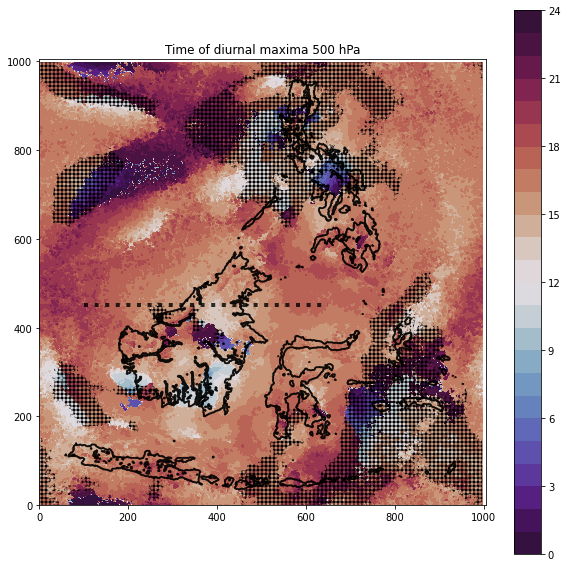

In [210]:
plt.figure(figsize=(10,10))
plt.set_cmap('twilight_shifted')

plt.subplot(1,1,1, aspect='equal')
plot = plt.contourf(np.argmax(all_Tv[:,:,:], axis=0), levels=np.arange(0,25,1))

#Add Land outline
plt.contour(all_const.FR_LAND, colors='black', alpha=0.3)

#Mask for reagons with small amplitude
amplitude = all_Tv[:,:,:].max(axis=0) - all_Tv[:,:,:].min(axis=0)
hatches = np.greater(amplitude, 0.2) #Half the daily amplitude, about 25% of all the points
plt.contourf(hatches, colors='none', hatches=['+++'], levels=[0,0.5])


plt.title('Time of diurnal maxima 500 hPa')

#Add horizontal line where cross section is
ilat = 450
wlon = 100
elon = 650
plt.plot([wlon, elon], [ilat, ilat], 'k', linewidth=4, linestyle='dotted', alpha=0.8)

plt.colorbar(plot)

plt.savefig('Tv_Max.png')


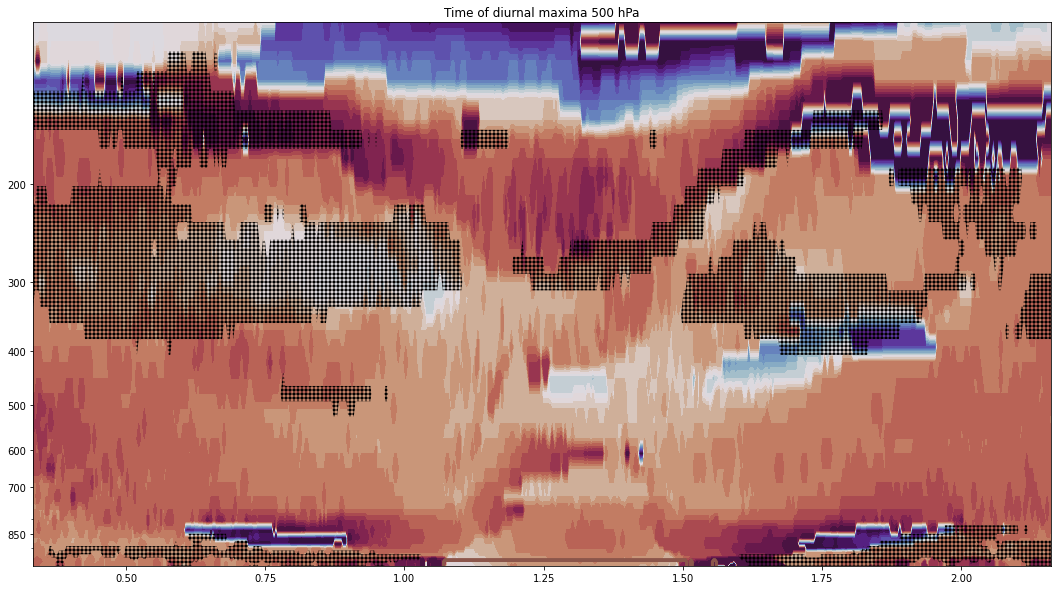

In [209]:
ilat = 450
wlon = 100
elon = 650
x = all_const.lon[ilat,wlon:elon] * 111 /  1000 #in km
y = all_P.P[:,:,ilat,wlon:elon].mean(axis=(0,2)) / 100

#Upper level of plot
plevel=100
lvl = (np.abs(y - plevel)).argmin().values

#Copute virtual temperature
T = all_T.T[:,:,ilat,wlon:elon]
P = all_P.P[:,:,ilat,wlon:elon]
RH = all_RELHUM.RELHUM[:,:,ilat,wlon:elon]

a_Tv = mpcalc.virtual_temperature(T, mpcalc.mixing_ratio_from_relative_humidity(RH, T, P))

#Lower Boundary (island outline)
islands = np.zeros_like(a_Tv[0,:,:])
islands[-3:,:] = all_const.FR_LAND[ilat,wlon:elon].values.copy()

#Mask for reagons with small amplitude
amplitude = a_Tv.max(axis=0) - a_Tv.min(axis=0)
hatches = np.greater(amplitude.magnitude, 0.2) #Half the daily amplitude, about 25% of all the points

plt.figure(figsize=(31,10))
plt.set_cmap('twilight_shifted')

plt.subplot(1,1,1, aspect='equal')
plot = plt.contourf(x, y[lvl:], a_Tv[:, lvl:,:].argmax(axis=0), levels=np.arange(0,25,1))
plt.contour(x, y[lvl:], islands[lvl:,:], colors='C5', alpha=1)
plt.contourf(x, y[lvl:], hatches[lvl:,:], colors='none', hatches=['+++'], levels=[0,0.5])
plt.title('Time of diurnal maxima 500 hPa')
plt.yscale('log')
plt.ylim(100,1000)
plt.yticks([1000, 850, 700, 600, 500, 400, 300, 200, 100], ['1000', '850', '700', '600', '500', '400', '300', '200', '100'])
plt.axis('scaled')

plt.gca().invert_yaxis()

plt.savefig('Tv_vert_Max.png')


In [16]:
print("haha")

haha
